In [1]:
from extract_text import TextExtractor

/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
impressions="right pleural effusion and no left pleural effusion"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/text_embed"  
file_name='aidan_kate_test_rightpleur_noleft.npy'

In [3]:
text_extractor = TextExtractor(resume_model="/media/volume/gen-ai-volume/MedSyn/models/test_run2")
text_extractor.run(impressions, output_folder, file_name)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of CXRBertModel were not initialized from the model checkpoint at microsoft/BiomedVLP-CXR-BERT-specialized and are newly initialized: ['classifier.bias

<All keys matched successfully>
File already exists: /media/volume/gen-ai-volume/MedSyn/results/text_embed/aidan_kate_test_rightpleur_noleft.npy and /media/volume/gen-ai-volume/MedSyn/results/text_embed/aidan_kate_test_rightpleur_noleft_tokens.npy


In [ ]:
from stage1 import run_diffusion_1
import accelerate
accelerate.state.AcceleratorState._shared_state.clear() # dirty hack to reset accelerator state
run_diffusion_1(input_folder="/media/volume/gen-ai-volume/MedSyn/results/text_embed", 
                output_folder= "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/aidan_kate_test_rightpleur_noleft", 
                model_folder="/media/volume/gen-ai-volume/MedSyn/models/stage1", 
                attention_folder="/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/aidan_kate_test_rightpleur_noleft",
                dont_delete_folder="/media/volume/gen-ai-volume/MedSyn/results/img_64_standard",
                num_sample=1,
                tokenizer=text_extractor.tokenizer,
                noise_folder="/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/saved_noise/aidan_kate_test_rightpleur_noleft")

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

generated_filename = "aidan_kate_test_rightpleur_noleft_sample_0.npy"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/aidan_kate_test_rightpleur_noleft"
image_path = os.path.join(output_folder, generated_filename)

generated_image = np.load(image_path)  # Shape: (C, D, H, W) or (C, num_slices, height, width)
print(f"Loaded image shape: {generated_image.shape}")  # Check image dimensions

Loaded image shape: (4, 64, 64, 64)


In [3]:
from scipy.ndimage import zoom
import numpy as np
import matplotlib.pyplot as plt
import os

Loaded generated images with shape: (4, 64, 64, 64)
Sample shape: (64, 64, 64)
Loaded heatmaps with shape: (64, 8, 8)
Final heatmap volume shape: (64, 64, 64)


<Figure size 2500x2000 with 0 Axes>

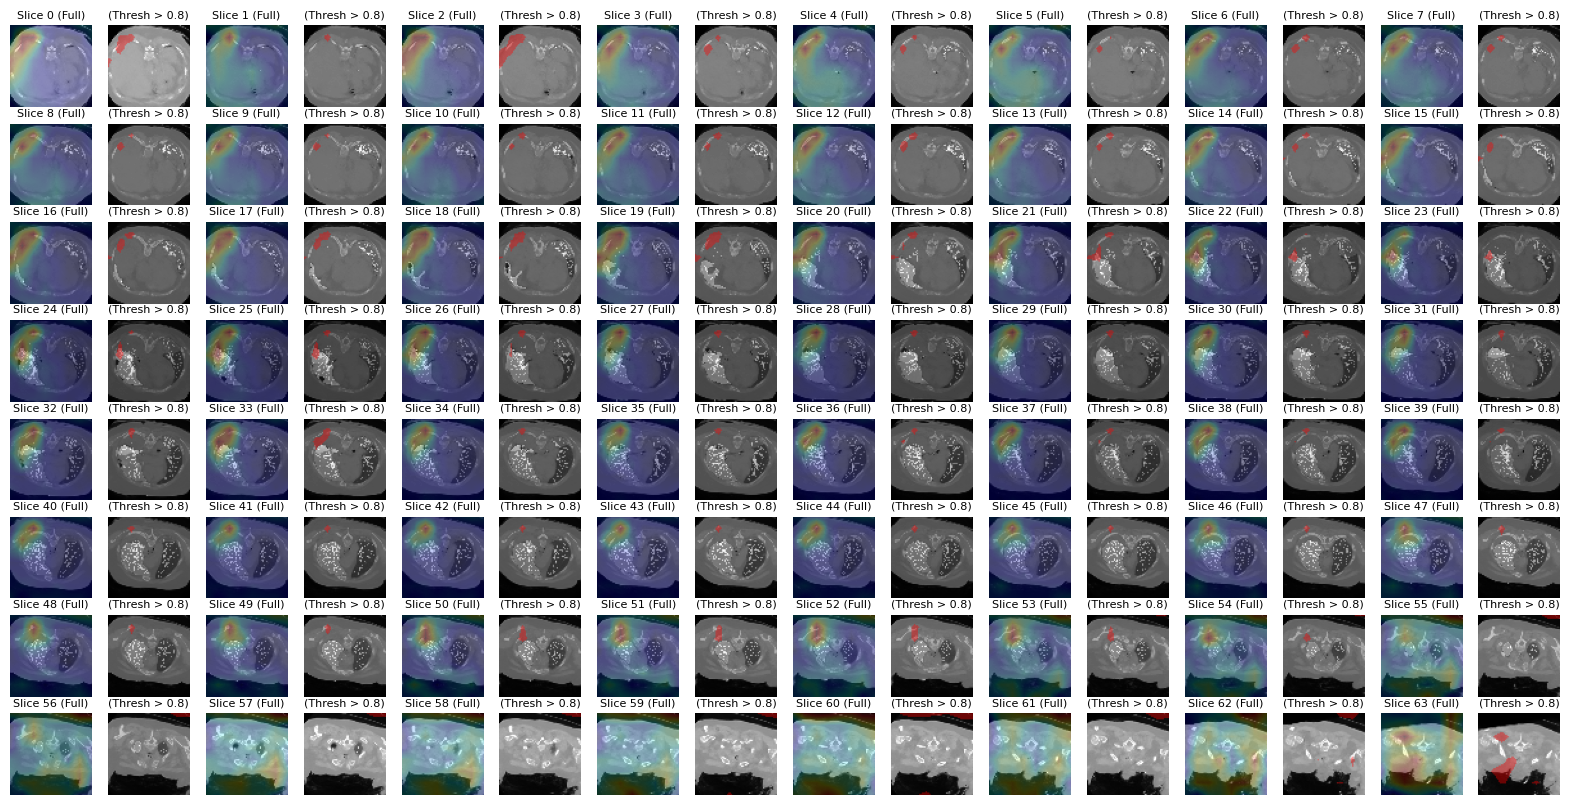

In [15]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min + 1e-8)

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min + 1e-8)

def overlay_heatmap_on_slices(volume, heatmap_volume, view='axial', n_rows=8, n_cols=8, threshold=0.5):
    if view == 'axial':
        slices = volume
        heatmap_slices = heatmap_volume
    elif view == 'coronal':
        slices = np.transpose(volume, (1, 0, 2))
        heatmap_slices = np.transpose(heatmap_volume, (1, 0, 2))
    elif view == 'sagittal':
        slices = np.transpose(volume, (2, 0, 1))
        heatmap_slices = np.transpose(heatmap_volume, (2, 0, 1))
    else:
        raise ValueError("Invalid view. Choose from 'axial', 'coronal', or 'sagittal'.")

    num_slices = slices.shape[0]
    total_plots = min(n_rows * n_cols, num_slices)  # Prevent index errors
    fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(20, 10))  # Twice the columns for comparison
    axes = axes.flatten()

    for idx in range(total_plots):
        slice_idx = idx  
        if slice_idx >= num_slices:
            axes[idx * 2].axis('off')
            axes[idx * 2 + 1].axis('off')
            continue

        image_slice = slices[slice_idx, :, :]
        image_slice_norm = normalize_image(image_slice)

        heatmap_slice = heatmap_slices[slice_idx, :, :]
        heatmap_slice_norm = normalize_image(heatmap_slice)

        # Plot full heatmap overlay (Left Column)
        axes[idx * 2].imshow(image_slice_norm, cmap='gray')
        axes[idx * 2].imshow(heatmap_slice_norm, cmap='jet', alpha=0.2)
        axes[idx * 2].set_title(f'Slice {slice_idx} (Full)', fontsize=8)
        axes[idx * 2].axis('off')

        # Plot thresholded red transparent overlay (Right Column)
        threshold_mask = heatmap_slice_norm > threshold
        red_mask = np.zeros((*heatmap_slice_norm.shape, 4))  # RGBA
        red_mask[..., 0] = 1  # Red channel
        red_mask[..., 3] = threshold_mask * 0.4  # Apply alpha where mask is True

        axes[idx * 2 + 1].imshow(image_slice_norm, cmap='gray')
        axes[idx * 2 + 1].imshow(red_mask)
        axes[idx * 2 + 1].set_title(f'(Thresh > {threshold})', fontsize=8)
        axes[idx * 2 + 1].axis('off')

    plt.tight_layout  # Adjust spacing
    plt.show()


image_data_path = image_path
heatmap_data_path = '/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/aidan_kate_test_rightpleur_noleft/aidan_kate_test_rightpleur_noleft_sample_0.npy_token_1_right_heatmaps.npy'

# Load the generated images
data = np.load(image_data_path)
print(f"Loaded generated images with shape: {data.shape}")

#add a dummy batch dimension
data_batched = np.expand_dims(data, axis=0)

# Average over channels if multiple channels exist
sample = data_batched[0].mean(axis=0)  # [frames, height, width]
num_frames, height, width = sample.shape
print(f"Sample shape: {sample.shape}")
sample_norm = normalize_image(sample)
heatmaps = np.load(heatmap_data_path)
print(f"Loaded heatmaps with shape: {heatmaps.shape}")
if heatmaps.shape[1] != height or heatmaps.shape[2] != width:
    resized_heatmaps = []
    for i in range(num_frames):
        heatmap_slice = heatmaps[i, :, :]  # e.g. (8, 8)
        heatmap_slice_norm = normalize_image(heatmap_slice)
        zoom_factors = (height / heatmap_slice.shape[0], width / heatmap_slice.shape[1])
        heatmap_resized = zoom(heatmap_slice_norm, zoom_factors, order=1)  # Bilinear interpolation
        resized_heatmaps.append(heatmap_resized)
    heatmap_volume = np.stack(resized_heatmaps, axis=0)  # (frames, height, width)
else:
    heatmap_volume = heatmaps

print(f"Final heatmap volume shape: {heatmap_volume.shape}")
view = 'axial'

plt.figure(figsize=(25, 20))
overlay_heatmap_on_slices(sample_norm, heatmap_volume, view='axial', n_rows=8, n_cols=8, threshold=0.8)

<Figure size 2500x2000 with 0 Axes>

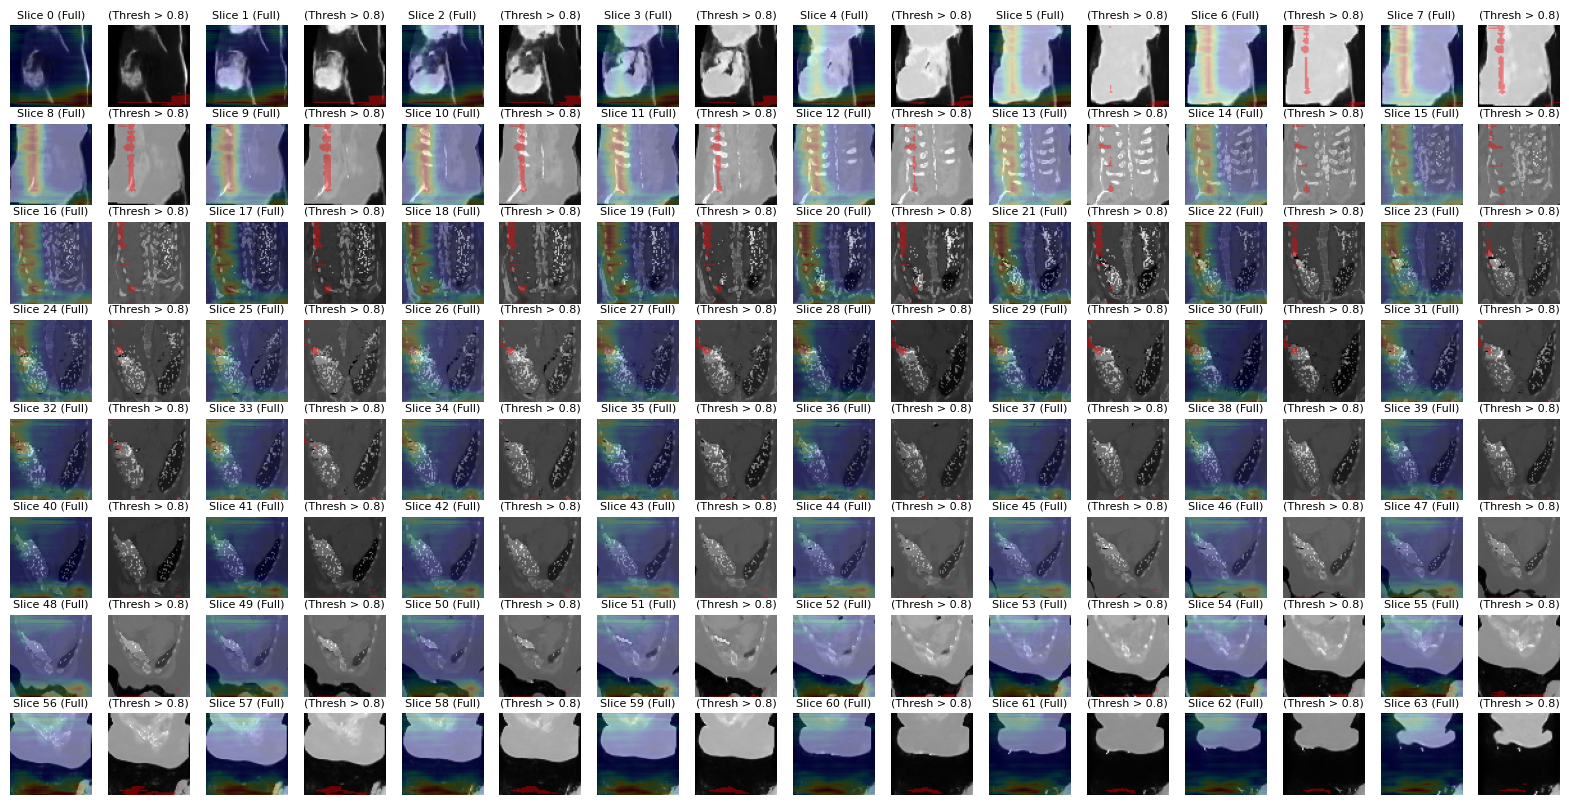

In [16]:
view = 'coronal'

plt.figure(figsize=(25, 20))
plt.suptitle(f"Overlay of CLS Heatmaps - View: {view.capitalize()}", fontsize=16)
overlay_heatmap_on_slices(sample_norm, heatmap_volume, view=view, n_rows=8, n_cols=8, threshold=0.8)

<Figure size 1500x1500 with 0 Axes>

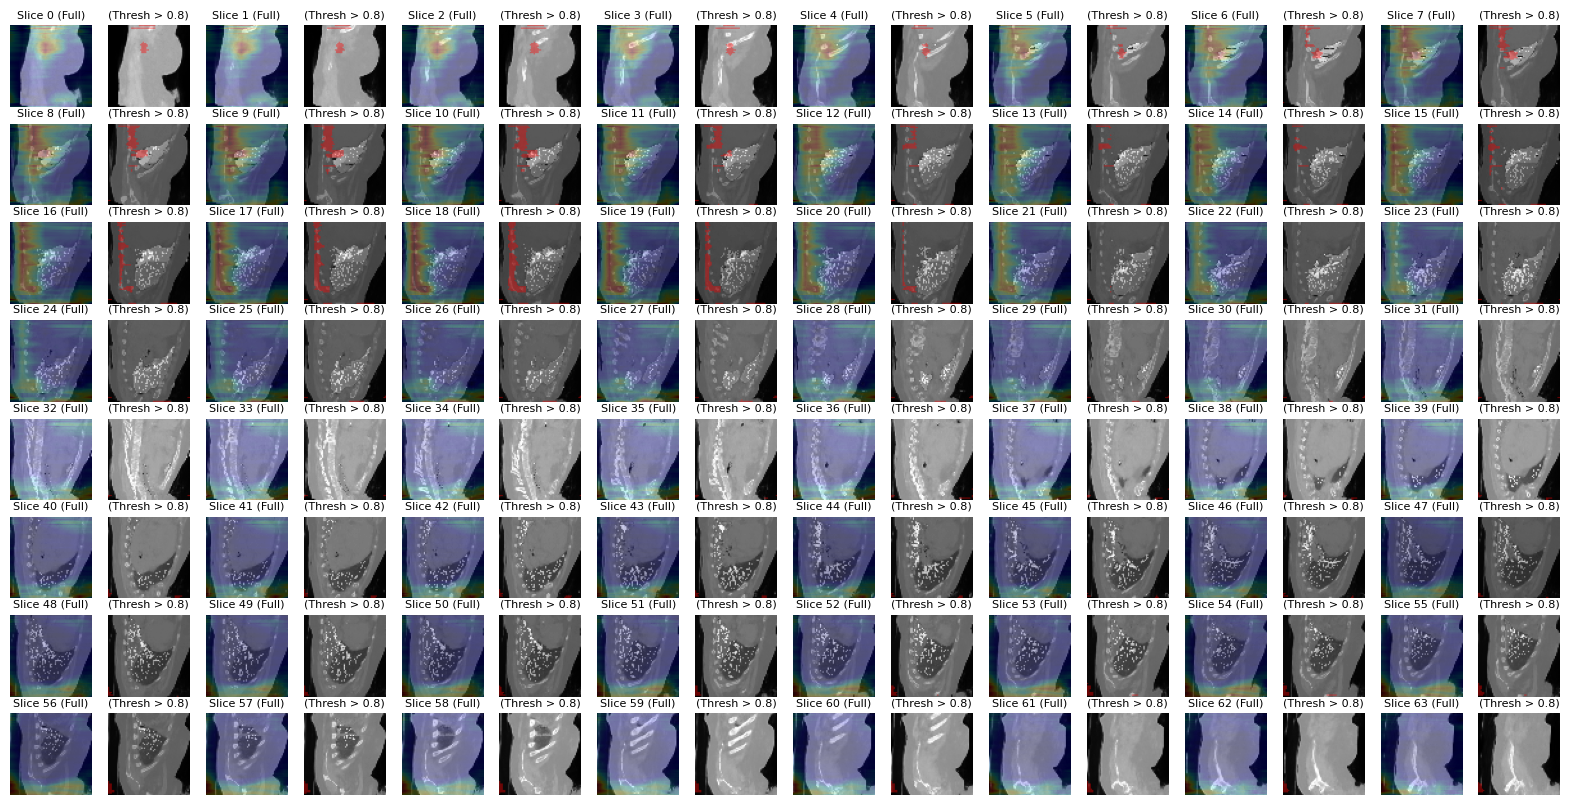

In [17]:
view = 'sagittal'

plt.figure(figsize=(15, 15))
plt.suptitle(f"Overlay of CLS Heatmaps - View: {view.capitalize()}", fontsize=16)
overlay_heatmap_on_slices(sample_norm, heatmap_volume, view=view, n_rows=8, n_cols=8, threshold=0.8)

In [18]:
from stage2 import run_diffusion_2
import accelerate
accelerate.state.AcceleratorState._shared_state.clear() # dirty hack to reset accelerator state

run_diffusion_2(input_folder="/media/volume/gen-ai-volume/MedSyn/results/img_64_standard", 
                        output_folder="/media/volume/gen-ai-volume/MedSyn/results/img_256_standard", 
                        model_folder="/media/volume/gen-ai-volume/MedSyn/models/stage2",
                        filename="aidan_kate_test_rightpleur_noleft.npy",
                        num_series_exists=0)

/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


Number of parameters: 54307908
Map Location: cuda
Model path: /media/volume/gen-ai-volume/MedSyn/models/stage2/1000_ckpt/pytorch_model.bin


/home/exouser/MedsynBackend/src/stage2.py:1110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=map_location), s

found 1 videos as gif files at /media/volume/gen-ai-volume/MedSyn/results/img_64_standard
loading model...
Load accelerator state: /media/volume/gen-ai-volume/MedSyn/models/stage2/1000_ckpt


/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/accelerate/checkpointing.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(input

training model...
num_samples: 1
High Resolution: 100%|██████████| 21/21 [01:26<00:00,  4.13s/it]


In [21]:
from dicom_helpers import nifti_to_dicom

FILES_FOLDER = "/media/volume/gen-ai-volume/MedSyn/results/"
foldername = "aidan_kate_test_rightpleur_noleft"
filename = "aidan_kate_test_rightpleur_noleft"
sample_number = "0"
num_series_exists = 0

nifti_file = os.path.join(FILES_FOLDER,"img_256_standard",filename+"_sample_" + str(num_series_exists) + ".nii.gz")
output_folder = os.path.join(FILES_FOLDER,"dicom",filename+"_sample_" + str(num_series_exists))

nifti_to_dicom(nifti_file=nifti_file,
                output_folder=output_folder,
                series_description="right pleural effusion and no left pleural effusion",                      
                series_instance_uid="00000011111",
                study_instance_uid="00000011111",
                patient_name="Aidan Kate Test",
                patient_id="00000011111")

Store DICOM files in Folder: /media/volume/gen-ai-volume/MedSyn/results/dicom/aidan_kate_test_rightpleur_noleft_sample_0


/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '00000011111'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Conversion complete. DICOM files are saved in /media/volume/gen-ai-volume/MedSyn/results/dicom/aidan_kate_test_rightpleur_noleft_sample_0


In [22]:
def generate_pmap(heatmap_volume, threshold=0.5):
    """
    Convert a heatmap into a binary probability map (PMAP).
    
    Args:
        heatmap_volume (numpy.ndarray): The original heatmap volume (3D).
        threshold (float): The threshold to binarize the heatmap.

    Returns:
        numpy.ndarray: A binary probability map (same shape as heatmap_volume).
    """
    pmap = (heatmap_volume > threshold).astype(np.float32)  # Convert to 0 and 1
    return pmap

pmap = generate_pmap(heatmap_volume, threshold=0.6)
print(f"PMAP shape: {pmap.shape}, Unique values: {np.unique(pmap)}")  # Should only contain 0 and 1

PMAP shape: (64, 64, 64), Unique values: [0. 1.]


In [41]:
import pydicom
import highdicom as hd
from datetime import datetime
from highdicom.pm import ParametricMap, RealWorldValueMapping
from pydicom.uid import generate_uid
from scipy.ndimage import zoom

def resize_pmap(pmap, target_shape):
    """
    Resize the probability map (PMAP) to match DICOM slice dimensions.

    Args:
        pmap (numpy.ndarray): Original PMAP (slices, height, width).
        target_shape (tuple): (num_slices, height, width) from DICOM.

    Returns:
        numpy.ndarray: Resized PMAP matching the DICOM shape.
    """
    zoom_factors = (target_shape[0] / pmap.shape[0],  # Adjust slices
                    target_shape[1] / pmap.shape[1],  # Adjust height
                    target_shape[2] / pmap.shape[2])  # Adjust width

    pmap_resized = zoom(pmap, zoom_factors, order=1)  # Bilinear interpolation
    return pmap_resized


def load_dicom_series(directory):
    """
    Load all DICOM slices from a directory and sort them by Instance Number.

    Args:
        directory (str): Path to the folder containing DICOM files.

    Returns:
        list[pydicom.Dataset]: Sorted list of DICOM datasets.
    """
    dicom_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    dicom_datasets = [pydicom.dcmread(f) for f in dicom_files]

    # Sort slices by Instance Number to ensure correct order
    dicom_datasets.sort(key=lambda x: int(x.InstanceNumber))
    
    return dicom_datasets

def attach_pmap_to_dicom_series(dicom_dir, pmap, filename):
    """
    Attach a PMAP to a DICOM CT series and save it as a multi-frame DICOM PMAP.

    Args:
        dicom_dir (str): Path to the directory containing DICOM slices.
        pmap (numpy.ndarray): The PMAP array (same size as the DICOM volume).

    Returns:
        str: Path to the saved PMAP DICOM file.
    """
    # Load DICOM series
    dicom_series = load_dicom_series(dicom_dir)

    # Get DICOM shape
    num_slices = len(dicom_series)
    dicom_height, dicom_width = dicom_series[0].Rows, dicom_series[0].Columns

    # Resize PMAP if dimensions do not match
    if pmap.shape != (num_slices, dicom_height, dicom_width):
        print(f"Resizing PMAP from {pmap.shape} to ({num_slices}, {dicom_height}, {dicom_width})")
        pmap = resize_pmap(pmap, (num_slices, dicom_height, dicom_width))

    pmap = pmap.astype(np.float32)
    # Generate metadata
    series_instance_uid = generate_uid()
    instance_uid = generate_uid()
    now = datetime.now()

    # ✅ Define a valid RealWorldValueMapping (Identity Mapping)
    real_world_value_mappings = [
        RealWorldValueMapping(
            lut_label="Identity",
            lut_explanation="Probability Map (0-1 range)",
            unit=hd.sr.coding.Code("1", "UCUM", "No Units"),
            value_range=(0.0, 1.0),
            slope=1.0,
            intercept=0.0
        )
    ]

    # Create Parametric Map (Multi-frame)
    parametric_map = ParametricMap(
        source_images=dicom_series,  # Use full DICOM series
        pixel_array=pmap,  # Already resized
        series_instance_uid=series_instance_uid,
        sop_instance_uid=instance_uid,
        manufacturer="Your Organization",
        manufacturer_model_name="AI Model XYZ",
        software_versions="1.0.0",
        device_serial_number="0000",
        contains_recognizable_visual_features=False,
        real_world_value_mappings=real_world_value_mappings, 
        window_center=0.5,  # Helps display PMAP properly (0 to 1 range)
        window_width=1.0,  # Ensures PMAP contrast scaling works
        series_description="PMAP: Thresholded Region",
        series_number=1,  
        instance_number=1
    )

    # Save the PMAP as a DICOM file
    pmap_save_path = "/media/volume/gen-ai-volume/MedSyn/results/dicom_overlays"
    output_pmap_path = os.path.join(pmap_save_path, filename, f"{filename}_output_pmap.dcm")
    os.makedirs(os.path.dirname(output_pmap_path), exist_ok=True)  
    parametric_map.save_as(output_pmap_path)

    print(f"Saved PMAP DICOM to {output_pmap_path}")
    return output_pmap_path


In [42]:
dicom_dir = "/media/volume/gen-ai-volume/MedSyn/results/dicom/aidan_kate_test_rightpleur_noleft_sample_0"
pmap = generate_pmap(heatmap_volume, threshold=0.8)

# Attach PMAP to the DICOM CT scan series
output_pmap_dicom = attach_pmap_to_dicom_series(dicom_dir, pmap, "aidan_kate_test_rightpleur_noleft_sample_0")


Resizing PMAP from (64, 64, 64) to (256, 256, 256)
Saved PMAP DICOM to /media/volume/gen-ai-volume/MedSyn/results/dicom_overlays/aidan_kate_test_rightpleur_noleft_sample_0/aidan_kate_test_rightpleur_noleft_sample_0_output_pmap.dcm
